# Nancy Grace Roman Space Telescope<br>Solve for Reference Pixel  Frequency Dependent Weights for all Roman Flight Candidates

Bernard J. Rauscher
NASA Goddard Space Flight Center

25 May 2021

e-Mail: Bernard.J.Rauscher@nasa.gov

## 1. INTRODUCTION

This notebook shows to to compute the Linear Algebra Machine Learning (LAML) frequency dependent weights for the reference pixels in columns.

## 2. COMPUTING THE FREQUENCY DEPENDENT WEIGHTS

Here is the computation with running commentary.

In [1]:
# Load standard packages
using Dates
using Revise         # Helpful for interactive sessions
using Glob           # Filename globbing
using Plots          # Used all the time...
using FITSIO         # Working with astronomy FITS files
using LaTeXStrings   # Used to make nice plot labels
using OMEinsum       # Tensor operations
using JLD            # Julia Data format, used for saving and restoring results
using Statistics     # Needed for mean(), std(), and the like
using StatsBase      # Adds robust statistics tools
using LinearAlgebra  # The name says it all

# Load my packages
using SIRS

The next cell defines where the input data are and where to write results. These assume that you are working on Nancy Grace Roman Space Telescope Data archived on the National Center for Climate Simulation ADAPT system.

In [2]:
ddir = "/att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/"  # Data are here
rdir = "/att/gpfsfs/briskfs01/ppl/brausche/roman_caldir/SIRS_Results_3/"; # Results go here

The files are archived in a set of directories. Write a little helper to search through them.

In [3]:
function eglob(pattern, home)
    files = String[]
    paths = glob("*", home)
    for path in paths
        if isdir(path); files = glob(pattern, path); end
        if length(files) > 0; break; end
    end
    return(files)
end;

In [4]:
# These are the flight candidates as of 3/18/21
sca_list = ["20663","20828","20829","20833","20849",
            "21224","21225","21226","21317","21319",
            "21440","21442","21443","21641","21643",
            "21645","21813","21814","21815","21816",
            "21946","21947","22066","22067"];

n_complete = 22; # Number completed so far. This will be time consuming.
                # This facilitates re-starts when the connection drops
                # as it sometimes does.

Some SCAs would not process. These include the following.

* 20828 (many high std outputs)

In [5]:
function doit(sca_list, n_complete, output_directory)
    
    # Keep track of the last output file
    last = []
    
    # Loop over unfinished parts
    for i in n_complete+1:length(sca_list)
            
        # Make a list of files
        files = eglob("*_95k_1p1m0p1_noise_"*sca_list[i]*"_*.fits", ddir)
        if length(files)<1
            continue
        else
            println("Processing SCA ", sca_list[i]) 
        end
        
        #=
        Here is a template for the results filenames;
           2021-03-19T12:18:18_HyC_20663_95.0K_1.0V_SIRS.jld.
        Define identifying information
        =#
        f = FITS(files[1], "r")
        H = read_header(f[1])
        close(f)
        naxis3 = H["NREADS"]   # Number of up-the-ramp reads
        scatemp = H["SCATEMP"] # Kelvin, SCA temperature
        nout = 32              # Roman uses 32 outputs
        nroh = 7               # Provided by DCL staff
        τ    = 5.e-6           # Seconds, Dwell time per pixel
        vdetbias = "1.0V"      # Volts, 1 Volt planned for flight.
                               #   make string since this is only
                               #   used as part of a filename.
        
        # Instantiate a SIRSCore structure. Since we do not
        # have good pixels masks for all SCAs, take the SIRS
        # default which automatically rejects statistical outliers.
        sc = SIRSCore("h4rg", nout, nroh, τ, naxis3)
        
         for file in files
            # Show some status
            println("Processing file: ", file)
   
            # Work with ADAPT format files.
            # Don't worry about DCL format for now.
            f = FITS(file, "r")
            D = Float64.(dropdims(read(f[2]), dims=4))
            close(f)
            
            # Coadd
            coadd!(sc, D)
        end
        
        # Solve for alpha and beta
        solve!(sc);
        
        # Save results
        output_filename = rdir *
                            string(now())[1:19] * "_" * string(sca_list[i]) *
                            "_" * string(scatemp) * "K" *
                            "_" * vdetbias *
                            "_SIRS.jld"
        SIRS.save(sc, output_filename)
        
        # Save last
        last = output_filename
        
     end
    
end;

In [6]:
doit(sca_list, n_complete, rdir);

Processing SCA 22066
Processing file: /att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/22066_21996_22067_21441/20210430_95k_1p1m0p1_noise_22066_001.fits
Processing file: /att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/22066_21996_22067_21441/20210430_95k_1p1m0p1_noise_22066_002.fits
Processing file: /att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/22066_21996_22067_21441/20210430_95k_1p1m0p1_noise_22066_003.fits
Processing file: /att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/22066_21996_22067_21441/20210430_95k_1p1m0p1_noise_22066_004.fits
Processing file: /att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/22066_21996_22067_21441/20210430_95k_1p1m0p1_noise_22066_005.fits
Processing file: /att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/22066_21996_22067_21441/20210430_95k_1p1m0p1_noise_22066_006.fits
Processing file: /att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/22066_21996_22067_21441/20210430_95k_1p1m0p1_noise_22066_007.fits
Processing file: /att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/22066_21996_2

Make some plots showing the behavior at low and high frequency.

In [9]:
sc = SIRS.restore("/att/gpfsfs/briskfs01/ppl/brausche/roman_caldir/SIRS_Results_3/2021-06-07T10:15:20_22067_95.0K_1.0V_SIRS.jld");

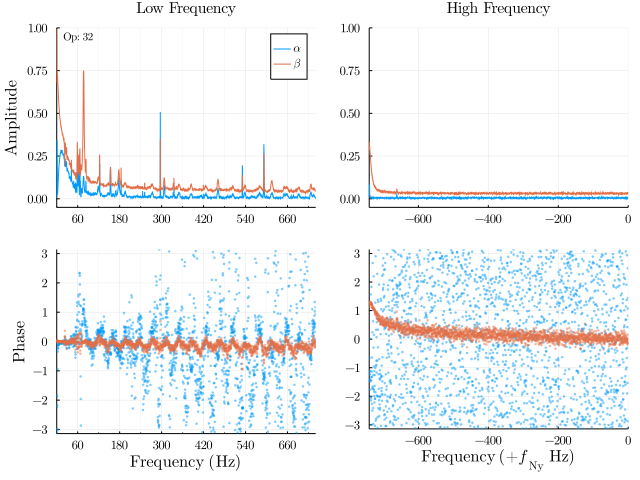

In [12]:
wplot(sc, 32, nice=true)